In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

## AUTOENCODER

### A. RECONSTRUCT MNIST IMAGES

In [2]:
# LOAD DATA

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.', one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [5]:
# BUILDING GRAPH

learning_rate = .01
training_epochs = 20
batch_size = 256
display_step = 1
examples_to_show = 10

n_hidden_1 = 256
n_hidden_2 = 128
n_input = 784

X = tf.placeholder('float', [None, n_input])
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}

def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2 
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

y_pred = decoder_op
y_true = X
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAINING

sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
for epoch in range(training_epochs):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c = sess.run([optimizer, cost], feed_dict={X:batch_xs})
    if epoch % display_step == 0:
        print('Epoch: ', '%04d' % (epoch+1),
              'cost = ', '{:.9f}'.format(c))
print('Optimization Finished!')

Epoch:  0001 cost =  0.207949370
Epoch:  0002 cost =  0.173900798
Epoch:  0003 cost =  0.156220704
Epoch:  0004 cost =  0.146398678
Epoch:  0005 cost =  0.137867615
Epoch:  0006 cost =  0.131847635
Epoch:  0007 cost =  0.129538938
Epoch:  0008 cost =  0.127903253
Epoch:  0009 cost =  0.123290122
Epoch:  0010 cost =  0.121567547
Epoch:  0011 cost =  0.118081354
Epoch:  0012 cost =  0.118547820
Epoch:  0013 cost =  0.114866965
Epoch:  0014 cost =  0.116010740
Epoch:  0015 cost =  0.112460002
Epoch:  0016 cost =  0.113365144
Epoch:  0017 cost =  0.108549118
Epoch:  0018 cost =  0.108949758
Epoch:  0019 cost =  0.108671769
Epoch:  0020 cost =  0.105899520
Optimization Finished!


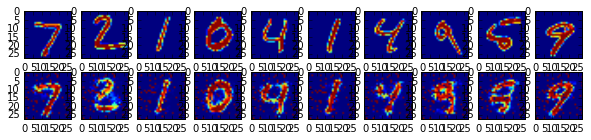

In [8]:
# RECONSTRUCTION

encode_decode = sess.run(y_pred, feed_dict={X:mnist.test.images[:examples_to_show]})
f, a = plt.subplots(2, 10, figsize=(10, 2))
for i in range(examples_to_show):
    a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
    a[1][i].imshow(np.reshape(encode_decode[i],(28,28)))
    
sess.close()

### B. DBN

In [2]:
# LOAD DATA

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.', one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [5]:
# PRE-TRAIN: STACKED RBM

class RBM(object):
    
    def __init__(self, input_size, output_size):
        
        self._input_size = input_size
        self._output_size = output_size
        self.epochs = 5
        self.learning_rate = 1.
        self.batchsize = 100
        
        self.w = np.zeros([input_size, output_size], np.float32)
        self.hb = np.zeros([output_size], np.float32)
        self.vb = np.zeros([input_size], np.float32)
        
    def prob_h_given_v(self, visible, w, hb):
        
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)
    
    def prob_v_given_h(self, hidden, w, vb):
        
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    
    def sample_prob(self, probs):
        
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))
    
    def train(self, X):
        
        _w = tf.placeholder('float', [self._input_size, self._output_size])
        _hb = tf.placeholder('float', [self._output_size])
        _vb = tf.placeholder('float', [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], np.float32)
        prv_hb = np.zeros([self._output_size], np.float32)
        prv_vb = np.zeros([self._input_size], np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], np.float32)
        cur_hb = np.zeros([self._output_size], np.float32)
        cur_vb = np.zeros([self._input_size], np.float32)   
        v0 = tf.placeholder('float', [None, self._input_size])
        
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb)) # forward pass
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb)) # backward pass
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb + self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb + self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(self.epochs):
                for start,end in zip(range(0,len(X),self.batchsize),range(self.batchsize,len(X),self.batchsize)):
                    batch = X[start:end]
                    cur_w, cur_hb, cur_vb = sess.run([update_w,update_hb,update_vb],
                                                     feed_dict={v0:batch,_w:prv_w,_hb:prv_hb,_vb:prv_vb})
                    prv_w, prev_hb, prv_vb = cur_w, cur_hb, cur_vb
                error = sess.run(err, feed_dict={v0:batch,_w:prv_w,_hb:prv_hb,_vb:prv_vb})
                print('Epoch: %d' % epoch, ' reconstruction error: %f' % error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
        
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out)

RBM_hidden_sizes = [500, 200, 50]
inpX = trX
rbm_list = []
input_size = inpX.shape[1]
for i,size in enumerate(RBM_hidden_sizes):
    print('RBM: ', i, ' ', input_size, '->', size)
    rbm_list.append(RBM(input_size, size))
    input_size = size
    
for rbm in rbm_list:
    print('New RBM:')
    rbm.train(inpX)
    inpX = rbm.rbm_output(inpX)

RBM:  0   784 -> 500
RBM:  1   500 -> 200
RBM:  2   200 -> 50
New RBM:
Epoch: 0  reconstruction error: 0.050820
Epoch: 1  reconstruction error: 0.048902
Epoch: 2  reconstruction error: 0.043644
Epoch: 3  reconstruction error: 0.044553
Epoch: 4  reconstruction error: 0.044060
New RBM:
Epoch: 0  reconstruction error: 0.039494
Epoch: 1  reconstruction error: 0.033448
Epoch: 2  reconstruction error: 0.032353
Epoch: 3  reconstruction error: 0.030208
Epoch: 4  reconstruction error: 0.029047
New RBM:
Epoch: 0  reconstruction error: 0.049457
Epoch: 1  reconstruction error: 0.045648
Epoch: 2  reconstruction error: 0.043139
Epoch: 3  reconstruction error: 0.044567
Epoch: 4  reconstruction error: 0.044148


In [9]:
# REGULAR NN

class NN(object):
    
    def __init__(self, sizes, X, Y, X_test, Y_test):
        
        self._sizes = sizes
        self._X = X
        self._Y = Y
        self._X_test = X_test
        self._Y_test = Y_test
        self.w_list = []
        self.b_list = []
        self._learning_rate = 1.
        self._momentum = 0.
        self._epoches = 10
        self._batchsize = 100
        input_size = X.shape[1]
        
        for size in self._sizes + [Y.shape[1]]: # Y.shape at the end is for the output layer.
            max_range = 4*math.sqrt(6./(input_size+size)) # truncated uniform.
            self.w_list.append(np.random.uniform(-max_range, max_range, [input_size, size]).astype(np.float32))
            self.b_list.append(np.zeros([size], np.float32))
            input_size = size
            
    def load_from_rbms(self, dbn_sizes, rbm_list):
        
        assert len(dbn_sizes)==len(self._sizes)
        
        for i in range(len(self._sizes)):
            self.w_list[i] = rbm_list[i].w
            self.b_list[i] = rbm_list[i].hb
            
    def train(self):
        
        _a = [None] * (len(self._sizes) + 2) # 3 layers of RMB + 1 layer of NN + 1 layer for output.
        _w = [None] * (len(self._sizes) + 1)
        _b = [None] * (len(self._sizes) + 1)
        _a[0] = tf.placeholder('float', [None, self._X.shape[1]])
        y = tf.placeholder('float', [None, self._Y.shape[1]])
        
        for i in range(len(self._sizes) + 1):
            _w[i] = tf.Variable(self.w_list[i])
            _b[i] = tf.Variable(self.b_list[i])
        for i in range(1, len(self._sizes) + 2):
            _a[i] = tf.nn.sigmoid(tf.matmul(_a[i-1], _w[i-1]) + _b[i-1]) # connect RBMS with NN.
        
        cost = tf.reduce_mean(tf.square(_a[-1] - y))
        
        train_op = tf.train.MomentumOptimizer(self._learning_rate, self._momentum).minimize(cost)
        predict_op = tf.argmax(_a[-1], 1)
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for epoch in range(self._epoches):
                for start,end in zip(range(0,len(self._X),self._batchsize),
                                     range(self._batchsize,len(self._X),self._batchsize)):
                    sess.run(train_op, feed_dict={_a[0]:self._X[start:end], y:self._Y[start:end]})
                for j in range(len(self._sizes) + 1): # train the combined network.
                    self.w_list[j] = sess.run(_w[j])
                    self.b_list[j] = sess.run(_b[j])
                print(
                      "Accuracy rating (Train) for epoch " + str(epoch) + ":" + \
                      str(np.mean(np.argmax(self._Y,axis=1) == 
                                  sess.run(predict_op, feed_dict={_a[0]:self._X, y:self._Y})))
                     )
            print("Optimization Finished!\n")
            print(
                  "Accuracy rating (Test):" + \
                  str(np.mean(np.argmax(self._Y_test,axis=1) == 
                              sess.run(predict_op, feed_dict={_a[0]:self._X_test, y:self._Y_test})))
                  )            

nn = NN(RBM_hidden_sizes, trX, trY, teX, teY)
nn.load_from_rbms(RBM_hidden_sizes, rbm_list)
nn.train()

Accuracy rating (Train) for epoch 0:0.565781818182
Accuracy rating (Train) for epoch 1:0.6616
Accuracy rating (Train) for epoch 2:0.695
Accuracy rating (Train) for epoch 3:0.711654545455
Accuracy rating (Train) for epoch 4:0.722654545455
Accuracy rating (Train) for epoch 5:0.731472727273
Accuracy rating (Train) for epoch 6:0.743236363636
Accuracy rating (Train) for epoch 7:0.780381818182
Accuracy rating (Train) for epoch 8:0.886763636364
Accuracy rating (Train) for epoch 9:0.903054545455
Optimization Finished!

Accuracy rating (Test):0.9088
